# Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

# Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [5]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
9.321829462000096
GPU (s):
2.130654915999912
GPU speedup over CPU: 4x


# Setting up

In [6]:
!pip install librosa

In [0]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import librosa.output
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

# Importing Dataset

In [8]:
!rm -rf ./sample_data/*
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('./sample_data/raw')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1hNxLdzo8GyzwD6EGuJNdye6N1h0mcRlX' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('./sample_data/noise')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'18WwnYEglonXHw7cHZnL_iYTrNAqaqliL' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: art001b.wav, id: 1sdn_UkM9q8I6Ds5xE3y_1Dzd1f_xMuC_
downloading to ./sample_data/raw/art001b.wav
title: art001a.wav, id: 1eDAkKgFUWCBb7-F_tQp1RIRGw4e0pCLF
downloading to ./sample_data/raw/art001a.wav
title: art002.wav, id: 1pyQlqNsM4NPkpcawp49KxwmdOYZLWar2
downloading to ./sample_data/raw/art002.wav
title: cafe3.wav, id: 1_ehjzpsbCd7dmZPitm6b9H80hJMjN-gX
downloading to ./sample_data/noise/cafe3.wav
title: cafe2.wav, id: 1ixwqu-dCCr2Q3QVTHAL6p57NEcJjB1l2
downloading to ./sample_data/noise/cafe2.wav
title: cafe1.wav, id: 1FWwT3KO0eSR9QOSVLwjri9LyK4IzkpFr
downloading to ./sample_data/noise/cafe1.wav


In [9]:
path = './sample_data/raw'
counter = 0
for parent, dirs, files in os.walk(path):
    for file in files:
        ext = os.path.splitext(file)[1][1:]
        if not parent.endswith(ext):
            dest = os.path.join(parent, ext)
            if not os.path.exists(dest):
                os.mkdir(dest)
            src, dest = os.path.join(parent, file), os.path.join(dest, file)
            os.rename(src, dest)
            counter += 1
            print('Moved {} to {}'.format(src, dest))
print('Moved {} files.'.format(counter))

Moved ./sample_data/raw/art001b.wav to ./sample_data/raw/wav/art001b.wav
Moved ./sample_data/raw/art002.wav to ./sample_data/raw/wav/art002.wav
Moved ./sample_data/raw/art001a.wav to ./sample_data/raw/wav/art001a.wav
Moved 3 files.


In [0]:
def load(filename):
    return librosa.load(filename)
    
def stretch(data, r = 1.0):
    return librosa.effects.time_stretch(data, r)
    
def noise(x, **params):
    noise = np.zeros(x.shape)
    noise_type = params['type'] if 'type' in params else 'white'
    if noise_type == 'white':
        distribution = params['distribution'] if 'distribution' in params else 'gaussian'
        sigma = params['sigma'] if 'sigma' in params else 0.005
        if distribution == 'gaussian':
            noise = np.random.normal(scale = sigma, size = x.shape)
        elif distribution == 'uniform':
            noise = np.random.uniform(low = -sigma, high = sigma, size = x.shape)
    return x + noise

def plot(x, sr, title = 'Raw Data'):
    plt.figure(figsize = (14, 5))
    plt.title(title)
    librosa.display.waveplot(x, sr = sr)
    plt.show()
    
def save(filename, x, sr):
    librosa.output.write_wav(filename, x, sr)

In [11]:
np.random.seed(42)
df = pd.DataFrame(columns = ['input', 'output'])
path = './sample_data/raw'
noisy_path = '/noisy_wav'
counter = 0
SIGMA_LOW = 1e-3
SIGMA_HIGH = 5e-2
NOISE_PARAMS = {'type': 'white', 'distribution': 'gaussian', 'sigma': 0.002}
for parent, dirs, files in os.walk(path):
    if not parent.endswith('/wav'):
        print('SKIPPING: {}'.format(parent))
        continue
    dest_parent = parent.replace('/wav', noisy_path)
    if len(files) > 0 and not os.path.exists(dest_parent):
        os.mkdir(dest_parent)
    for file in files:
        src = os.path.join(parent, file)
        x, sr = load(src)
        NOISE_PARAMS['sigma'] = np.random.uniform(SIGMA_LOW, SIGMA_HIGH)
        x = noise(x, **NOISE_PARAMS)
        dest = os.path.join(dest_parent, '{}-{}'.format('-'.join([str(v) for v in NOISE_PARAMS.values()]), file))
        dest = dest.replace('0.0','0')
        save(dest, x, sr)
        df.loc[counter] = [dest, src]
        counter += 1
        print('Generated new noisy audio file and saved in {}!'.format(dest))
print('Generated {} new noisy audio files.'.format(counter))
df.to_csv(os.path.join(path, 'raw2noisy.csv'))

SKIPPING: ./sample_data/raw
Generated new noisy audio file and saved in ./sample_data/raw/noisy_wav/white-gaussian-019352465823520765-art001b.wav!
Generated new noisy audio file and saved in ./sample_data/raw/noisy_wav/white-gaussian-02523810012425846-art002.wav!
Generated new noisy audio file and saved in ./sample_data/raw/noisy_wav/white-gaussian-022018902262095616-art001a.wav!
Generated 3 new noisy audio files.


In [22]:
df.loc[0, 'input']

'./sample_data/raw/noisy_wav/white-gaussian-019352465823520765-art001b.wav'

In [23]:
input_file = df.loc[0, 'input']
x, sr = load(input_file)

NoBackendError: ignored

In [24]:
output_file = df.loc[0, 'output']
y, sr = load(output_file)
ipd.Audio(y, rate = sr)

In [3]:
N = 10000
X = np.zeros((len(df), N, 1))
Y = np.zeros((len(df), N, 1))
for i, row in df.iterrows():
  (X[i, :, 1], _), (Y[i, :, 1], _) = load(row['input']), load(row['output'])

NameError: ignored

In [0]:
import librosa
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
SEED = 42
N = 1000
SIGMA = 0.01
np.random.seed(SEED)

Y_train, sr = librosa.load('./sample_data/raw/wav/art001a.wav')
Y_train = Y_train[:N].reshape(1, N, 1)
X_train = Y_train + np.random.normal(scale = SIGMA, size = N).reshape(1, N, 1)

((1, 1000, 1), (1, 1000, 1))

# LSTM Autoencoder

In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense

Found GPU at: /device:GPU:0


In [5]:
N_CELLS = 256

model = Sequential()
model.add(LSTM(N_CELLS, activation = 'relu', input_shape = (N, 1), name = 'encoder'))
model.add(Dropout(0.3))
model.add(RepeatVector(N))
model.add(LSTM(N_CELLS, activation = 'relu', return_sequences = True, name = 'decoder'))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (LSTM)               (None, 256)               264192    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1000, 256)         0         
_________________________________________________________________
decoder (LSTM)               (None, 1000, 256)         525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 1000, 1)           257       
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________


In [11]:
EPOCHS = 50
BATCH_SIZE = 1
# fit model
history = model.fit(X_train, 
                    Y_train, 
                    epochs = EPOCHS, 
                    verbose = 1)

Epoch 1/50
1/1 [==============================] - 9s 9s/step - loss: 5.8959e-06
Epoch 2/50
1/1 [==============================] - 7s 7s/step - loss: 1.8647e-05
Epoch 3/50
1/1 [==============================] - 7s 7s/step - loss: 5.0569e-06
Epoch 4/50
1/1 [==============================] - 7s 7s/step - loss: 8.7808e-06
Epoch 5/50
1/1 [==============================] - 7s 7s/step - loss: 6.1915e-06
Epoch 6/50
1/1 [==============================] - 7s 7s/step - loss: 5.4604e-06
Epoch 7/50
1/1 [==============================] - 7s 7s/step - loss: 5.7210e-06
Epoch 8/50
1/1 [==============================] - 7s 7s/step - loss: 5.5647e-06
Epoch 9/50
1/1 [==============================] - 7s 7s/step - loss: 5.7426e-06
Epoch 10/50
1/1 [==============================] - 7s 7s/step - loss: 5.5405e-06
Epoch 11/50
1/1 [==============================] - 7s 7s/step - loss: 5.0849e-06
Epoch 12/50
1/1 [==============================] - 7s 7s/step - loss: 5.1292e-06
Epoch 13/50
1/1 [====================

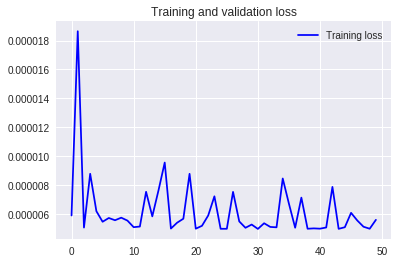

In [13]:
#train_mse = history.history['mse']
#validation_mse = history.history['val_mean_squared_error']
train_loss = history.history['loss']
#validation_loss = history.history['val_loss']

epochs = range(len(train_loss))

#plt.plot(epochs, train_mse, 'b-', label = 'Training MSE')
#plt.plot(epochs, validation_mse, 'r-', label = 'Validation MSE')
#plt.title('Training and validation MSE')
#plt.legend()

plt.figure()
plt.plot(epochs, train_loss, 'b-', label = 'Training loss')
#plt.plot(epochs, validation_loss, 'r-', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
# demonstrate recreation
Y_pred = model.predict(X_train, verbose = 0)
ipd.Audio(Y_pred.flatten(), rate = sr)

In [20]:
Y_pred.flatten()

array([ 1.7626474e-04,  8.3283288e-05,  1.3374374e-05, -4.2130676e-05,
       -8.7821478e-05, -1.2829987e-04, -1.6324854e-04, -1.9280889e-04,
       -2.1739493e-04, -2.3755911e-04, -2.5390324e-04, -2.6701906e-04,
       -2.7745395e-04, -2.8569429e-04, -2.9215802e-04, -2.9720008e-04,
       -3.0111356e-04, -3.0413808e-04, -3.0646639e-04, -3.0825290e-04,
       -3.0961938e-04, -3.1066188e-04, -3.1145525e-04, -3.1205735e-04,
       -3.1251399e-04, -3.1285911e-04, -3.1311976e-04, -3.1331644e-04,
       -3.1346435e-04, -3.1357553e-04, -3.1365894e-04, -3.1372174e-04,
       -3.1376872e-04, -3.1380370e-04, -3.1382995e-04, -3.1384962e-04,
       -3.1386435e-04, -3.1387529e-04, -3.1388321e-04, -3.1388950e-04,
       -3.1389392e-04, -3.1389730e-04, -3.1389968e-04, -3.1390172e-04,
       -3.1390300e-04, -3.1390411e-04, -3.1390486e-04, -3.1390545e-04,
       -3.1390591e-04, -3.1390620e-04, -3.1390649e-04, -3.1390661e-04,
       -3.1390678e-04, -3.1390678e-04, -3.1390690e-04, -3.1390696e-04,
      